In [1]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from io import BytesIO
import onnx
import torch
import onnxsim
import tensorrt as trt

In [2]:
model = YOLO('models/yolov8n.pt')

100%|██████████████████████████████████████████████████████████████████████████████| 6.23M/6.23M [00:02<00:00, 2.60MB/s]


# predict 

In [3]:
img_torch = model.predict('images/street.jpg')


image 1/1 /home/airi/Mylove/github/convertyolo2all/images/street.jpg: 448x640 17 persons, 9 cars, 2 buss, 3 traffic lights, 2 potted plants, 85.2ms
Speed: 4.9ms preprocess, 85.2ms inference, 55.9ms postprocess per image at shape (1, 3, 448, 640)


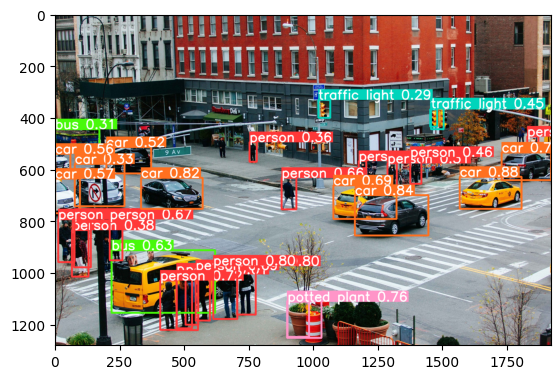

In [4]:
plt.imshow(img_torch[0].plot()[..., ::-1])

# pt2onnx

In [5]:
model = YOLO('models/yolov8n.pt')

In [6]:
b = 1
save_path = 'models/yolov8n.onnx'
model = model.model.fuse().eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for m in model.modules():
    m.to(device)
model.to(device)
fake_input = torch.randn((1,3,640,640)).to(device)
for _ in range(2):
    model(fake_input)
with BytesIO() as f:
    torch.onnx.export(model, fake_input, f, opset_version=11, input_names=['images'], output_names=['num_dets', 'bboxes', 'scores', 'labels'])
    f.seek(0)
    onnx_model = onnx.load(f)
onnx.checker.check_model(onnx_model)
shapes = [b, 1, b, 100, 4, b, 100, b, 100]
for i in onnx_model.graph.output:
    for j in i.type.tensor_type.shape.dim:
        try:
            j.dim_param = str(shapes.pop(0))
        except:
            break
try:
    onnx_model, check = onnxsim.simplify(onnx_model)
    assert check, 'assert check failed'
except Exception as e:
    print(f'Simplifier failure: {e}')
onnx.save(onnx_model, save_path)
print(f'ONNX export success, saved as {save_path}')

YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
/home/airi/miniconda3/envs/convert/lib/python3.9/site-packages/ultralytics/nn/modules/head.py:50: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif self.dynamic or self.shape != shape:


============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX export success, saved as models/yolov8n.onnx


# onnx predict

In [7]:
model_onnx = YOLO('models/yolov8n.onnx')
img_onnx = model_onnx.predict('images/street.jpg')

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify', or 'pose'.
Loading models/yolov8n.onnx for ONNX Runtime inference...
WARNING ⚠️ Metadata not found for 'model=models/yolov8n.onnx'

image 1/1 /home/airi/Mylove/github/convertyolo2all/images/street.jpg: 640x640 17 class0s, 9 class2s, 2 class5s, 4 class9s, 2 class58s, 54.9ms
Speed: 1.5ms preprocess, 54.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


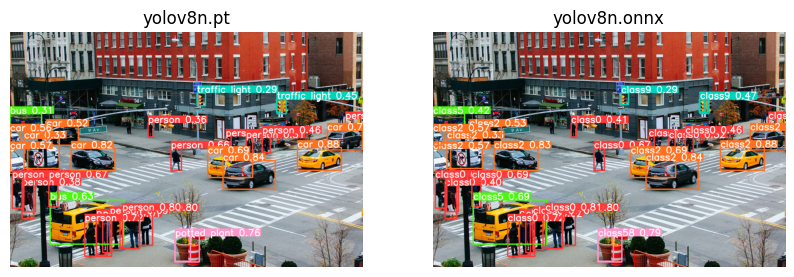

In [8]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_torch[0].plot()[..., ::-1])
ax1.set_title('yolov8n.pt')
ax1.axis('off')
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(img_onnx[0].plot()[..., ::-1])
ax2.set_title('yolov8n.onnx')
ax2.axis('off')
plt.show()

# pt2tf
we convert onnx , then make tf or tflite

In [9]:
import onnx
import tensorflow as tf
from onnx_tf.backend import prepare
import cv2

/home/airi/miniconda3/envs/convert/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [10]:
model_onnx = onnx.load('models/yolov8n.onnx')
tf_model = prepare(model_onnx)

In [11]:
tf_model.export_graph('models/tf_yolov8n')

INFO:absl:Function `__call__` contains input name(s) x, y with unsupported characters which will be renamed to onnx_tf_prefix__model_22_sub_x, onnx_tf_prefix__model_22_mul_2_y in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: models/tf_yolov8n/assets


INFO:tensorflow:Assets written to: models/tf_yolov8n/assets
INFO:absl:Writing fingerprint to models/tf_yolov8n/fingerprint.pb


# pt2tflite

In [12]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model('models/tf_yolov8n')
# tell converter which type of optimization techniques to use
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# convert the model 
tflite_model = converter.convert()

# save models
with open('models/tflite_yolov8n.tflite', 'wb') as f:
    f.write(tflite_model)

# pt2engine

In [13]:
from TensorRT import engine
device = 'cuda' if torch.cuda.is_available() else 'cpu'
engine_build = engine.EngineBuilder('models/yolov8n.onnx' , device)
engine_build.seg = True
engine_build.build(fp16=False,
              input_shape=[1, 3, 640, 640],
              iou_thres=0.65,
              conf_thres=0.25,
              topk=100)

[09/25/2023-17:40:37] [TRT] [W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[09/25/2023-17:40:37] [TRT] [W] input "images" with shape: (1, 3, 640, 640) dtype: DataType.FLOAT
[09/25/2023-17:40:37] [TRT] [W] output "num_dets" with shape: (1, 84, 8400) dtype: DataType.FLOAT
[09/25/2023-17:40:37] [TRT] [W] output "bboxes" with shape: (1, 144, 80, 80) dtype: DataType.FLOAT
[09/25/2023-17:40:37] [TRT] [W] output "scores" with shape: (1, 144, 40, 40) dtype: DataType.FLOAT
[09/25/2023-17:40:37] [TRT] [W] output "labels" with shape: (1, 144, 20, 20) dtype: DataType.FLOAT
[09/25/2023-17:42:11] [TRT] [W] Build tensorrt engine finish.
Save in /home/airi/Mylove/github/convertyolo2all/models/yolov8n.engine
